In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRAIN_DIR = '/kaggle/input/face-expression-recognition-dataset/images/train/'
TEST_DIR = '/kaggle/input/face-expression-recognition-dataset/images/validation/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/face-expression-recognition-data...,angry
1,/kaggle/input/face-expression-recognition-data...,happy
2,/kaggle/input/face-expression-recognition-data...,happy
3,/kaggle/input/face-expression-recognition-data...,happy
4,/kaggle/input/face-expression-recognition-data...,angry


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/face-expression-recognition-data...,surprise
1,/kaggle/input/face-expression-recognition-data...,surprise
2,/kaggle/input/face-expression-recognition-data...,surprise
3,/kaggle/input/face-expression-recognition-data...,surprise
4,/kaggle/input/face-expression-recognition-data...,surprise


<AxesSubplot: xlabel='label', ylabel='count'>

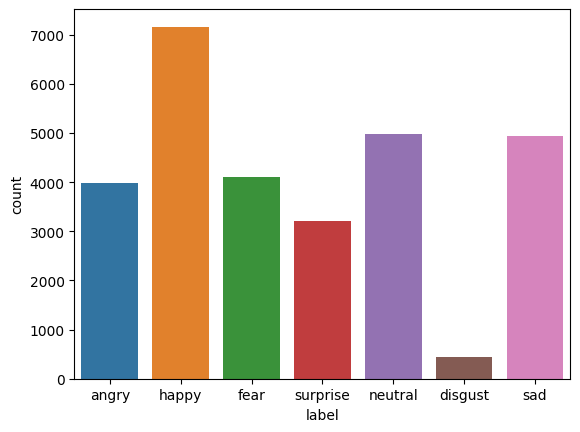

In [6]:
sns.countplot(train , x = 'label' )

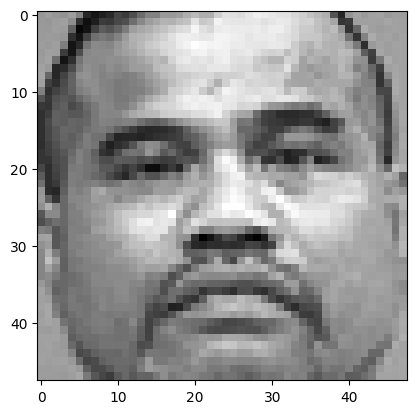

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

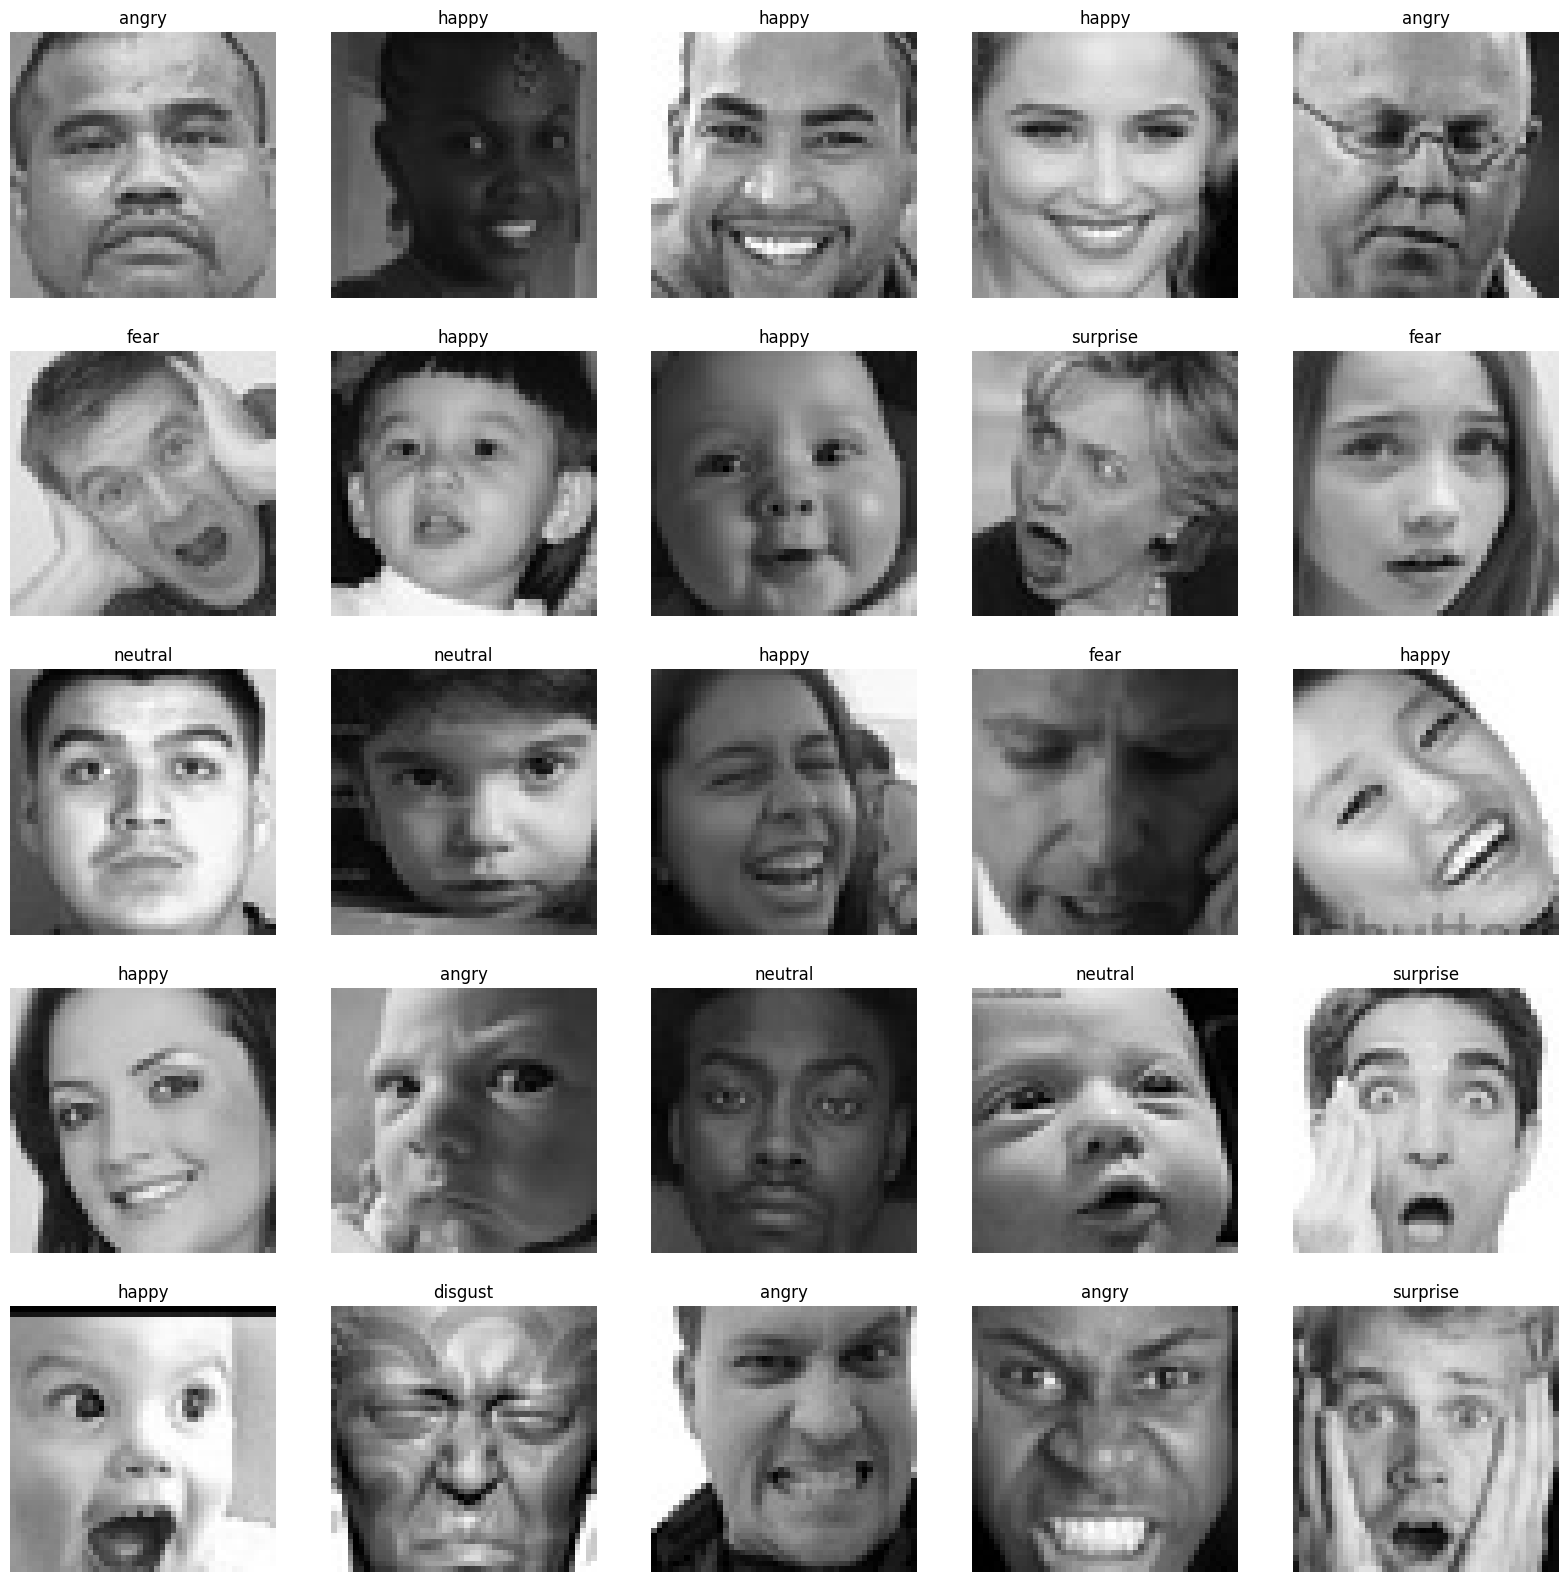

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [12]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
# convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [15]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [16]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.summary()
# train the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 256)       0

In [17]:
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


2023-05-11 05:02:43.457645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


226/226 [==============================] - 17s 35ms/step - loss: 1.8231 - accuracy: 0.2445 - val_loss: 1.8096 - val_accuracy: 0.2583
Epoch 2/100
226/226 [==============================] - 7s 32ms/step - loss: 1.8125 - accuracy: 0.2491 - val_loss: 1.7863 - val_accuracy: 0.2605
Epoch 3/100
226/226 [==============================] - 7s 32ms/step - loss: 1.7882 - accuracy: 0.2546 - val_loss: 1.7294 - val_accuracy: 0.2894
Epoch 4/100
226/226 [==============================] - 7s 32ms/step - loss: 1.7096 - accuracy: 0.2988 - val_loss: 1.6332 - val_accuracy: 0.3428
Epoch 5/100
226/226 [==============================] - 7s 31ms/step - loss: 1.6158 - accuracy: 0.3580 - val_loss: 1.5082 - val_accuracy: 0.4230
Epoch 6/100
226/226 [==============================] - 7s 32ms/step - loss: 1.5223 - accuracy: 0.4081 - val_loss: 1.4089 - val_accuracy: 0.4728
Epoch 7/100
226/226 [==============================] - 7s 32ms/step - loss: 1.4515 - accuracy: 0.4409 - val_loss: 1.3604 - val_accuracy: 0.4827
Epo

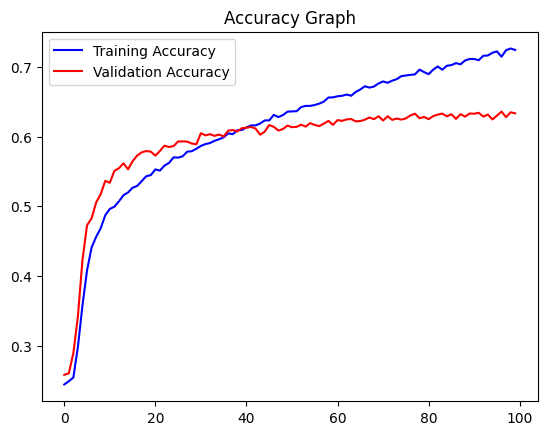

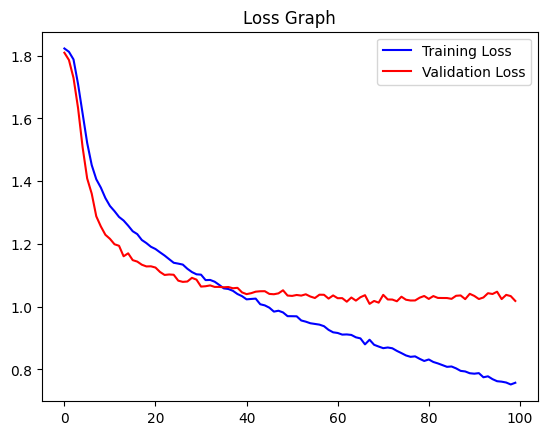

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [19]:
model.save('./Saved_model.h5')